In [20]:
import pandas as pd
import numpy as np
import os
import keras
import matplotlib.pyplot as plt
from keras.layers import Dense,GlobalAveragePooling2D

from keras.applications import VGG16

from keras.models import Model

from keras.models import Sequential
from keras.layers.convolutional import Convolution2D
from keras.engine import InputLayer
import cv2
import glob


ImportError: cannot import name 'preprocess_input'

In [2]:
base_model=VGG16(weights='imagenet',include_top=False) #imports the VGG model and discards the last 1000 neuron layer.

x=base_model.output
x=GlobalAveragePooling2D()(x)
x=Dense(1024,activation='relu')(x) #we add dense layers so that the model can learn more complex functions and classify for better results.
x=Dense(1024,activation='relu')(x) #dense layer 2
x=Dense(512,activation='relu')(x) #dense layer 3
preds=Dense(1,activation='sigmoid')(x) #final layer with sigmoid activation

In [3]:
model=Model(inputs=base_model.input,outputs=preds)
model.load_weights("final_model.h5")
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, None, None, 3)     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, None, None, 128)   0         
__________

In [4]:
from keras.models import Sequential
from keras.layers.convolutional import Convolution2D
from keras.engine import InputLayer
import keras

def to_fully_conv(model):

    new_model = Sequential()

    #input_layer = InputLayer(input_shape=(None, None, 3), name="input_new")

    #new_model.add(input_layer)

    for layer in model.layers:
        print(layer)
        if "GlobalAveragePooling2D" in str(layer):
            flattened_ipt = True
            f_dim = layer.input_shape

        elif "Dense" in str(layer):

            input_shape = layer.input_shape
            output_dim =  layer.get_weights()[1].shape[0]
            W,b = layer.get_weights()

            if flattened_ipt:
                shape = (f_dim[1],f_dim[2],f_dim[3],output_dim)
                new_W = W.reshape(shape)
                new_layer = Convolution2D(output_dim,
                                          (f_dim[1],f_dim[2]),
                                          strides=(1,1),
                                          activation=layer.activation,
                                          padding='valid',
                                          weights=[new_W,b])
                flattened_ipt = False

            else:
                shape = (1,1,input_shape[1],output_dim)
                new_W = W.reshape(shape)
                new_layer = Convolution2D(output_dim,
                                          (1,1),
                                          strides=(1,1),
                                          activation=layer.activation,
                                          padding='valid',
                                          weights=[new_W,b])


        else:
            new_layer = layer
            
        new_model.add(new_layer)
        flattened_ipt = False
    return new_model

In [5]:
########## Test Function #############
new_model = to_fully_conv(model)

# Example Image

In [6]:
example_not_stocked = "data/train/Not_Stocked/not_stocked_0_2371.jpeg"

In [7]:
example_stocked = "data/train/Stocked/stocked_0_2085.jpeg"

In [8]:
img_not_stocked = cv2.imread(example_not_stocked)
img_not_stocked = cv2.cvtColor(img_not_stocked, cv2.COLOR_BGR2RGB)

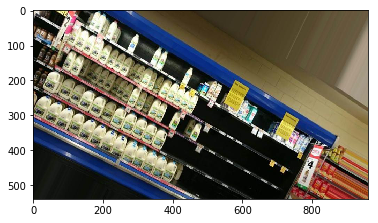

In [9]:
plt.imshow(img_not_stocked)

In [10]:
img_not_stocked.shape

(540, 960, 3)

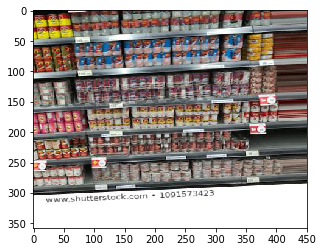

In [11]:
img_stocked = cv2.imread(example_stocked)
img_stocked = cv2.cvtColor(img_stocked, cv2.COLOR_BGR2RGB)
plt.imshow(img_stocked)

In [12]:
new_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, None, None, 128)   0         
_________________________________________________________________
block3_conv1 (Conv2D)        (None, None, None, 256)   295168    
__________

In [13]:
h,w = 105,105
img_not_stocked = cv2.resize(img_not_stocked,(h,w))

In [38]:
def process_pred_img(img, model):
    h,w = 105, 105
    img = cv2.resize(img,(h,w))
    img = img.reshape(1,w,h,3)
    return(img)



In [15]:
process_pred_img(img_not_stocked, new_model)

array([[[[0.]]]], dtype=float32)

In [16]:
process_pred_img(img_stocked, new_model)


array([[[[1.]]]], dtype=float32)

In [40]:
def draw(img, boxes, scores, classes, all_classes):
    for box, score, cl in zip(boxes, scores, classes):
        x, y, w, h = box
        
        top = max(0, np.floor(x + .5).astype(int))
        left = max(0, np.floor(y + .5).astype(int))
        right = min(img.shape[1], np.floor(x + w + .5).astype(int))
        bottom = min(img.shape[0], np.floor(y + h + .5).astype(int))
        
        cv2.rectangle(img, (top, left), (right, bottom), (255, 0, 0), 2)

In [41]:
def detect_img(img, model, all_classes):
    pimg = process_pred_img(img)
    start = time.time()
    boxes,classes, scores = model.predict(pimg, img.shape)
    end = time.time()
    print("time: {0:.2f}s".format(end-start))
    if boxes is not None:
        draw(img, boxes, scores, classes, all_classes)